<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/06_Testing_NNs_with_Season_Gaps_and_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing Neural Network Architecture

The following notebook tests NNs using the light-curves that are
  - Linearly intrapolated
  - use Gaussian process intropolation

The model is trained, tested, and evaluated. 

Author: Soumya Shreeram <br>
Script adapted from: Millon Martin & Kevin Müller <br>
Date: 23rd February 2020

Import all required python libraries

In [0]:
from google.colab import drive
import os
import pickle
import importlib
import itertools

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d 

%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

TensorFlow is already loaded. Please restart the runtime to change versions.


Mount google drive

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the dr; <strike>`dr`</strike>`0X_sameFileName`). dr stands for drive. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import nb_02i_preprocessing_data as dat
import nb_03_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = '/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images/'
save_model_dir = r'/content/gdrive/My Drive/Colab Notebooks/Models/'

### 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]

# select type of Interpolation
cubic, linear = False, True

""""select the type of nnet's to use
old_version :: borrowed from Martin & Kevins code
modified_version :: some minor changes compared to previous version
"""
old_version, modified_version = True, False

# reloads the file if any changes are made in the methods
importlib.reload(dat)

<module 'nb_02i_preprocessing_data' from '/content/gdrive/My Drive/Colab Notebooks/nb_02i_preprocessing_data.py'>

### 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [0]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, euler_sampling=True)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, sample_params)

for i, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, rad, v_t[v_t_idx], sample_params)
  
  # load data from the file
  l_curves, mjhd, err_mag_ml = dat.loadData(filename, l_curves, sample_params, i)
  out_catergories[i*sample_params[0]:(i+1)*sample_params[0]] = class_cat[1][i]
  out_radii[i*sample_params[0]:(i+1)*sample_params[0]] = r_0[i]

#### 2.1 Interpolation of the light curves

In [0]:
def interpolateLCurves(l_curves, mjhd, l_curves_interpolated, type_inter='linear'):
  """
  Function for interpolating the light curves 'linearly'
  @l_curves :: non-interpolated light curves 3Darray
  @l_curves_interpolated :: empty array with shape same as l_curves

  @Returns:: linearly interpolated light curves 3Darray
  """
  for i in range(len(l_curves)):
    # x array of times
    x = mjhd
    y = l_curves[i, :, 0]
    
    # interpolation
    f = interp1d(x,y, kind=type_inter)
    
    # capturing the features using y_inter
    xnew = np.linspace(x[0], x[-1], num=len(mjhd))
    y_inter = f(xnew)

    # setting the shape same as that on l_curves array
    y_inter.shape = (len(y_inter), 1)
    l_curves_interpolated = np.append(l_curves_interpolated, [y_inter], axis=0)
  return l_curves_interpolated, xnew

In [0]:
l_curves_interpolated = np.array([])
l_curves_interpolated.shape = (0, len(l_curves[0,:,0]),1)

# linear/cubic interpolated the light curves
if linear:
  lc_inter_linear, mjhd_inter = interpolateLCurves(l_curves, mjhd, l_curves_interpolated, \
                                       type_inter='linear')
  
if cubic:
  lc_inter_cubic, mjhd_inter = interpolateLCurves(l_curves, mjhd, l_curves_interpolated, \
                                      type_inter='cubic')

#### 2.1 Plots of some random light-curves

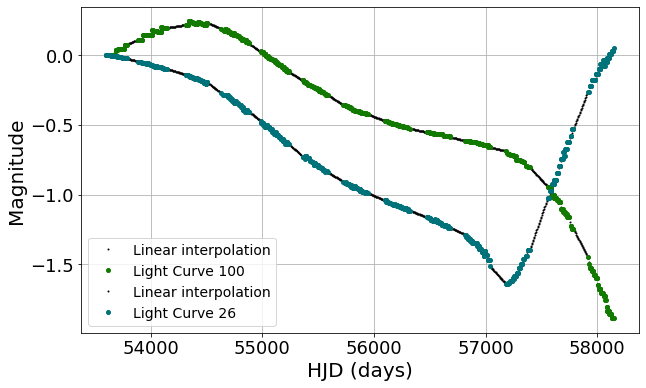

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
n = [100, 26]
colors = ['#127a00',  '#00727a', '#888894']

for i, num in enumerate(n):
  # light curves with cubic interpolation
  if cubic:
    ax.plot(mjhd_inter, lc_inter_cubic[n[i], :, 0], '.', color='r', label='Cubic interpolation', markersize=4)

  # light curves with linear interpolation
  ax.plot(mjhd_inter, lc_inter_linear[n[i], :, 0], '.', color='k', label='Linear interpolation', markersize=2)

  # without interpolation
  ax.plot(mjhd, l_curves[n[i], :], '.', color=colors[i], label='Light Curve %i'%(n[i]), markersize=8)

dat.setLabels(ax, 'HJD (days)', 'Magnitude', ticks=True, legend=True)
fig.savefig(save_image_dir+'/interpolated_lcurves.png') 

### 3. Generate training and testing data sets

Proceeding with linear interpolation.

In [0]:
train_l_curves, test_l_curves, data_sets, onehot_train, \
onehot_test = dat.generateTestTrain(lc_inter_linear, out_catergories, \
                                    out_radii, r_0)

### 4. Compiling the 3 networks

The three networks compiled here are coded in `04_Neural_Network_Designs.ipynb` that have been saved as `dr04_Neural_Network_Designs.py`, for ease of importing it. The python files can be found in the GitHub repo folder *python files*. 

Note that if you are running this from colab, need to have these `.py` files in your drive folder *Colab Notebooks*. 

Default constants that can be modified.

In [0]:
# choose which network to use (default CNN2)
CNN1, CNN2, ResNet = False, False, True
#CNN1, CNN2, ResNet = False, True,  False

# use old_version
old_version = True
modified_version = False

model_types = [CNN1, CNN2, ResNet]
model_name_list = ['CNN1','CNN2','ResNet']

for i in range(len(model_name_list)):
  if model_types[i]:
    model_name = model_name_list[i]
print('Using the Neural Network:', model_name)

Using the Neural Network: ResNet


The following code block uses the methods defined in the file `dr04_Neural_Network_Designs.py`: imported as **`nnet`**

Model parameters are defined in the methods in **`nnet`** additionally some more details:
* `num_hidden_nodes`: number of nodes in hidden fully connected layer
*`dropout_ratio`: % of nodes in the hidden layer to dropout during back-propagation update of the network weights

#### 4.1 Compiling CNN2

In [0]:
if CNN2:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  """--- CNN2 Model Parameters ---"""
  num_filter = (32, 32, 44, 44)
  kern_size = (21,21,15,15)
  maxpoolsize = (None, 15, None, 15)
  shortcut_link = (0,1,2,3)
  batch_norm = False
  dropout_ratio = 0.4  
  sampling = 3
  num_pieces = 1
  
  # prepare the data
  data_prep = nnet.prepareDataSampleCuts(test_l_curves, sampling, num_pieces)

  # build the model
  if old_version:
    num_hidden_nodes = 1500
    inputs, outputs = nnet.define_network_design4(num_filter, kern_size, \
                                                  maxpoolsize, num_hidden_nodes, \
                                                  dropout_ratio, shortcut_link, \
                                                  batch_norm, data_prep.shape[1], r_0)
  
  if modified_version:
    num_hidden_nodes = [1500]
    inputs, outputs = nnet.buildModelCNN2(sample_params[2], num_filter, kern_size, \
                                        maxpoolsize, num_hidden_nodes,\
                                        dropout_ratio, shortcut_link, batch_norm, \
                                        data_prep.shape[1], r_0)

  # compile the model
  # optimisation algorithm, loss (cost) function
  optimizer_type = Adam(lr=5e-4)  
  loss = 'categorical_crossentropy'  
  #accuracy metric to be determined after each epoch 
  metrics = ['categorical_accuracy'] 

  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                    metrics, save_image_dir+'CNN2', True)

  print('Network created')

(319,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 318, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 318, None, 32 704         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 318, None, 32 0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 318, None, 32 21536       activation_4[0][0]               
_______________________________________________________________________________________

#### 4.2 Compiling ResNet

In [0]:
if ResNet:
  # reloads the file if any changes are made
  importlib.reload(nnet)

  """--- ResNet Model Parameters ---"""
  num_filter = (32, 32, 32)
  kern_size = (10,20,50)
  n_block = 5
  maxpoolsize = 3
  num_hidden_nodes =[1000.0,]
  dropout_ratio = 0.7 
  batch_norm = True
  #If they are not 1, this network is not correctly defined.
  sampling = 1
  num_pieces = 1

  # build network
  if old_version:
    inputs, outputs = nnet.define_network_design_resnet(sample_params[2], num_filter, \
                                                        kern_size, n_block, \
                                                        maxpoolsize, num_hidden_nodes, \
                                                        dropout_ratio, r_0, \
                                                        batch_norm = True)
  if modified_version:
    inputs, outputs = nnet.defineResnet(sample_params[2], num_filter, \
                                           kern_size, n_block,maxpoolsize,\
                                           num_hidden_nodes, dropout_ratio, r_0,\
                                           batch_norm = batch_norm)
  
  learning_rate = 1e-4
  decay_rate = 0.0
  optimizer_type = Adam(lr=learning_rate, decay = decay_rate)  
  loss = 'categorical_crossentropy'  
  metrics = ['categorical_accuracy'] 

  model = nnet.compileDisplayNetwork(inputs, outputs, optimizer_type, loss, \
                                     metrics,save_image_dir+'ResNet', True)
  
  #model.load_weights('/content/gdrive/My Drive/Colab_Notebooks/Deep_learning_for_optical_IMaging/Resnet_weights.h5')

  print('Network created')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 955, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 955, None, 32 352         input_4[0][0]                    
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 955, None, 32 0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 955, None, 32 20512       activation_25[0][0]              
____________________________________________________________________________________________

### 5. Training the network

Constants used for training the network

In [0]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 30  # maxmimum number of epochs to be iterated
batch_size = 60   # batch size for the training data set
num_inputs = 1

In [0]:
if sampling == 1 and num_pieces == 1:
  model, history = nnet.fit_model_generator(model, train_l_curves, onehot_train, \
                    num_inputs = num_inputs, batch_size = batch_size, \
                    epochs = max_epochs, validation_split = validtrain_split_ratio, \
                    verbose = 1)
else:
  data_prep = nnet.prepareDataSampleCuts(train_l_curves, sampling, num_pieces)

  model, history = nnet.fit_model_generator(model, data_prep, onehot_train, \
                    num_inputs = num_inputs, batch_size = batch_size, \
                    epochs = max_epochs, validation_split = validtrain_split_ratio, \
                    verbose = 1)
  
print('Training completed')

Train on 6400 samples, validate on 1600 samples
Epoch 1/30
6400/6400 [==============================] - 128s 20ms/sample - loss: 2.8508 - categorical_accuracy: 0.0962 - val_loss: 2.3191 - val_categorical_accuracy: 0.1044
Epoch 2/30
6400/6400 [==============================] - 123s 19ms/sample - loss: 2.6663 - categorical_accuracy: 0.1045 - val_loss: 2.3291 - val_categorical_accuracy: 0.1019
Epoch 3/30
6400/6400 [==============================] - 122s 19ms/sample - loss: 2.4657 - categorical_accuracy: 0.1092 - val_loss: 2.3297 - val_categorical_accuracy: 0.1000
Epoch 4/30
6400/6400 [==============================] - 121s 19ms/sample - loss: 2.3500 - categorical_accuracy: 0.1189 - val_loss: 2.3164 - val_categorical_accuracy: 0.1019
Epoch 5/30
6400/6400 [==============================] - 122s 19ms/sample - loss: 2.2894 - categorical_accuracy: 0.1333 - val_loss: 2.2590 - val_categorical_accuracy: 0.1262
Epoch 6/30
6400/6400 [==============================] - 120s 19ms/sample - loss: 2.2489

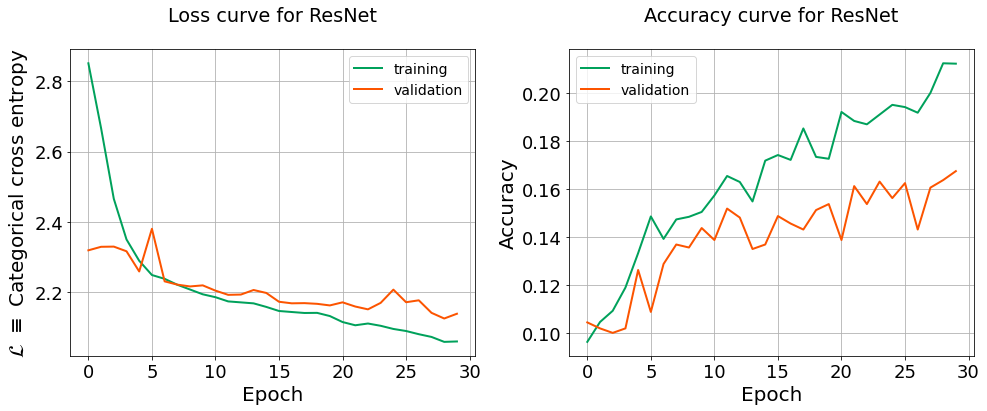

In [0]:
# plots the history
fig, ax = plt.subplots(1,2, figsize=(14,6))
labels = ['training', 'validation']
loss_Accuracy = ['loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy']

model_history = history.history
dat.plotLoss(ax[0], model_history, loss_Accuracy, model_name, labels)
dat.plotAccuracy(ax[1], model_history, loss_Accuracy, model_name, labels)
 
fig.savefig(save_image_dir+'/LandA_inter%s_epochs_%d.png'%(model_name, max_epochs))    
fig.tight_layout()

### 6. Displaying the classification report, confusion matrix

In [0]:
def evaluateAndPredict(model, test_l_curves, onehot_test, num_inputs):
  """
  Function evaluated the models and preducts the results
  @test_l_curves :: test data (arguments-> data_prep for CNN2)
  """
  evaluate_res = nnet.evaluate_model(model, test_l_curves, onehot_test, \
                                num_inputs = num_inputs, verbose = 1)

  print(evaluate_res[1])

  output_predict_onehot, output_ref_onehot = nnet.predict_model(model, test_l_curves, \
                                                                onehot_test, \
                                                                num_inputs = num_inputs, \
                                                                verbose = 1)
  return output_predict_onehot, output_ref_onehot

In [0]:
# prepare data with sample cuts and evaluate residuals
if CNN2:
  data_prep = nnet.prepareDataSampleCuts(test_l_curves, sampling, num_pieces)
  output_predict_onehot, output_ref_onehot = evaluateAndPredict(model, \
                                                                data_prep, \
                                                                onehot_test, \
                                                                num_inputs)
if ResNet:
  output_predict_onehot, output_ref_onehot = evaluateAndPredict(model, \
                                                                test_l_curves, \
                                                                onehot_test, \
                                                                num_inputs)
output_predict_c = np.argmax(output_predict_onehot, axis=1)
output_ref_c = np.argmax(output_ref_onehot, axis=1)

print('Test set classification report:\n')
print(classification_report(output_ref_c, output_predict_c,  \
                            target_names=output_class_names))

2000/2000 [==============================] - 8s 4ms/sample - loss: 2.1026 - categorical_accuracy: 0.1770
0.177
2000/2000 [==============================] - 8s 4ms/sample
Test set classification report:

              precision    recall  f1-score   support

           2       0.58      0.44      0.50       205
           4       0.19      0.46      0.27       191
          10       0.16      0.11      0.13       227
          15       0.09      0.22      0.13       194
          20       0.14      0.18      0.16       209
          30       0.11      0.04      0.06       190
          40       0.15      0.07      0.10       200
          60       0.15      0.05      0.08       203
          80       0.17      0.07      0.10       200
         100       0.12      0.14      0.13       181

    accuracy                           0.18      2000
   macro avg       0.19      0.18      0.17      2000
weighted avg       0.19      0.18      0.17      2000



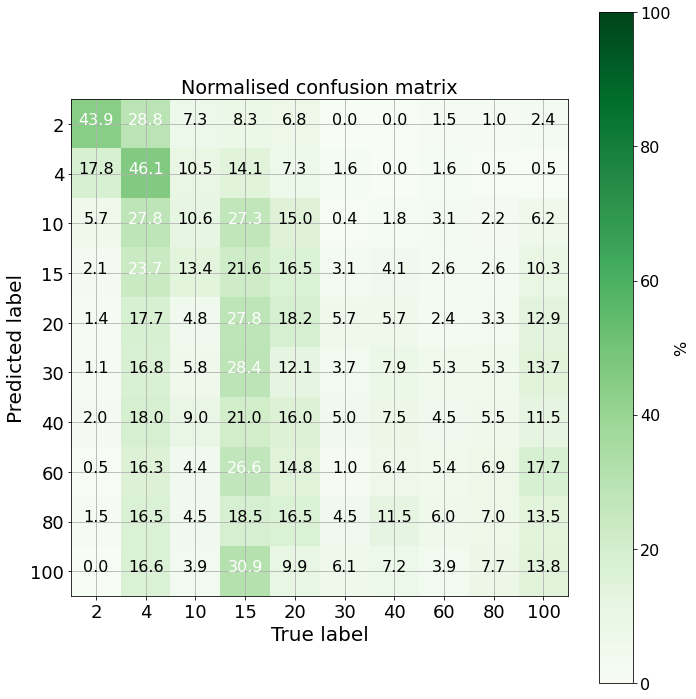

In [0]:
# need this to avoid callback errors
from sklearn.metrics import confusion_matrix
importlib.reload(dat)

# generate confusion matrix
cfm = confusion_matrix(output_ref_c, output_predict_c)  

# row normalisation of confusion matrix
cfm_probability = cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis]  
# confusion probability matrix
cfm_probability = cfm_probability * 100.0  

fig, ax = plt.subplots(1,1, figsize=(10,10))
dat.plotConfusionMatrix(ax, cfm_probability, output_class_names, 2)

# save figure
fig.savefig(save_image_dir+'/cfm_inter%s_epochs_%d.png'%(model_name, max_epochs))    
fig.tight_layout()